# Importing Libraries

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import requests
import json

# Getting data from GraphQL

In [52]:
accessToken='QmURZTQbn9R9nvuCCgAPJ6zcDayaRuMpWmxeyYEVxc5bxR'
endpoint='https://api.thegraph.com/subgraphs/name/muranox/uniswap-v3-matic' # from website

In [9]:
query="""query {
    pools{
        id
        createdAtTimestamp
        liquidity
        volumeUSD
        volumeToken0
        volumeToken1
        feesUSD
        feeTier
        }
}"""
r = requests.post(endpoint, json={"query": query})
print(json.dumps(r.json(), indent=2))


{
  "data": {
    "pools": [
      {
        "id": "0x001743596c8c1d9db739f361b4879909dd4e320c",
        "createdAtTimestamp": "1641120448",
        "liquidity": "0",
        "volumeUSD": "0",
        "volumeToken0": "0",
        "volumeToken1": "0",
        "feesUSD": "0",
        "feeTier": "10000"
      },
      {
        "id": "0x0048c7a3cd5cd28b1a2fcc1277bb3146ac33e3ff",
        "createdAtTimestamp": "1643118382",
        "liquidity": "0",
        "volumeUSD": "0",
        "volumeToken0": "0",
        "volumeToken1": "0",
        "feesUSD": "0",
        "feeTier": "10000"
      },
      {
        "id": "0x00b15004f026994582c07777ca837c535b2fcd88",
        "createdAtTimestamp": "1640209905",
        "liquidity": "0",
        "volumeUSD": "0",
        "volumeToken0": "0.076588481410774537",
        "volumeToken1": "23247.418369187447350224",
        "feesUSD": "0",
        "feeTier": "3000"
      },
      {
        "id": "0x00ca8e06bafa2fc1e079ec86d50f5248e7a6f7a8",
        "created

In [121]:
# Creating dataframe from output
data_frame = pd.json_normalize(r.json()['data']['pools']) 
# Loading in csv
data_frame.to_csv('pool_data.csv',index=False)

## Loading the data

In [122]:
pool_df=pd.read_csv('pool_data.csv')
pool_df.head()

,id,createdAtTimestamp,liquidity,volumeUSD,volumeToken0,volumeToken1,feesUSD,feeTier
0,0x001743596c8c1d9db739f361b4879909dd4e320c,1641120448,0,0,0.000000,0.000000,0,10000
1,0x0048c7a3cd5cd28b1a2fcc1277bb3146ac33e3ff,1643118382,0,0,0.000000,0.000000,0,10000
2,0x00b15004f026994582c07777ca837c535b2fcd88,1640209905,0,0,0.076588,23247.418369,0,3000
3,0x00ca8e06bafa2fc1e079ec86d50f5248e7a6f7a8,1640310980,0,0,0.033033,443163.112284,0,3000
4,0x00ec3195a0de6ab1d702e07a8ce42ae5b6ee12e1,1643143052,0,0,273.514799,0.195580,0,10000


In [123]:
# getting shape of data
pool_df.shape

(100, 8)

The data has 100 rows and 8 columns

### Data preprocessing

In [124]:
# Getting date from timestamp
pool_df['Date'] = pd.to_datetime(pool_df['createdAtTimestamp'], unit='s')

In [125]:
# dropping id and createdAtTimestamp
pool_df.drop(columns=['id','createdAtTimestamp'],axis=1,inplace=True)

In [126]:
# Creating necessary columns
pool_df['FeeTier']=pool_df['feeTier']/max(pool_df['feeTier'])
pool_df['liquidity']=pool_df['liquidity'].astype(float)
pool_df['FeesUSD/Liquidity']=pool_df['feesUSD']/pool_df['liquidity']
pool_df['FeesUSD/volumeUSD']=pool_df['feesUSD']/pool_df['volumeUSD']

In [128]:
# Groupby averages for a day
df_req=pool_df.groupby(pd.Grouper(key='Date',axis=0,freq='D')).mean()
df_req.head()

,liquidity,volumeUSD,volumeToken0,volumeToken1,feesUSD,feeTier,FeeTier,FeesUSD/Liquidity,FeesUSD/volumeUSD
Date,,,,,,,,,
2021-12-20,3.887644e+16,0.0,5.854763e+07,1.962532e+04,0.0,3000.000000,0.300000,0.0,NaN
2021-12-21,0.000000e+00,0.0,8.421374e+01,2.820882e+01,0.0,500.000000,0.050000,NaN,NaN
2021-12-22,4.495735e+09,0.0,1.431087e+01,1.220066e+04,0.0,3000.000000,0.300000,0.0,NaN
2021-12-23,9.677486e+20,0.0,2.767135e+03,4.908936e+04,0.0,7846.153846,0.784615,0.0,NaN
2021-12-24,3.366006e+20,0.0,3.813803e+05,1.018255e+06,0.0,4800.000000,0.480000,0.0,NaN


In [129]:
# Fee tier=0.05
df_req=df_req[df_req['FeeTier']==0.05]
# Dropping unnecessary columns
df_req.drop(columns=['feesUSD','feeTier'],axis=1,inplace=True)
df_req=df_req.reset_index()
# imputing NaN values by zero
df_req=df_req.fillna(0)

## Plotting the data

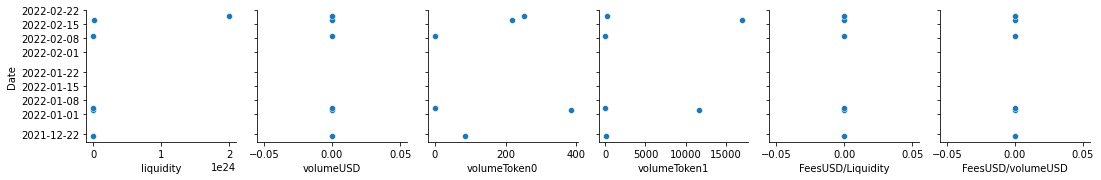

In [146]:
x_vars=['liquidity','volumeUSD','volumeToken0','volumeToken1','FeesUSD/Liquidity','FeesUSD/volumeUSD']
g=sns.PairGrid(df_req,diag_sharey=False,x_vars=x_vars,y_vars=['Date'])
g.map_offdiag(sns.scatterplot)